In [61]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from matplotlib import pyplot as plt
%matplotlib inline 
xp = cuda.cupy
import time


def model_func(model):
    if xp == np:
        pass
    else :
        gpu_device = 0
        cuda.get_device(gpu_device).use()
        model.to_gpu(gpu_device)
xp.model_init = model_func
xp.pi = np.pi

In [62]:
def make_data(N = 1000, L = 1000 , sc = 1):
    p = xp.random.randn(N,L)
    s = xp.random.uniform(0,1,size=(N,1))
    ret = p*s *sc
    return ret.astype(np.float32)
dat = make_data(10000,500,sc = 2)
print (dat)

[[ -5.51846862e-01  -1.56461582e-01  -1.07170355e+00 ...,   1.23189425e+00
   -7.78891027e-01  -9.74957049e-01]
 [  1.44218004e+00   5.18110633e-01   1.23154283e-01 ...,   1.58534491e+00
    1.69147050e+00  -2.15139461e+00]
 [ -1.97369531e-02   1.50839873e-02   1.27208885e-02 ...,  -8.69954005e-03
    3.08240904e-03  -2.11280379e-02]
 ..., 
 [  5.74688196e-01  -1.82098484e+00   3.19054151e+00 ...,  -2.28094053e+00
    3.76335680e-01  -1.17675805e+00]
 [  2.50674665e-01   1.69632420e-01  -1.39333993e-01 ...,  -6.25983477e-02
    6.11175746e-02   9.33102816e-02]
 [ -2.22832561e-01  -6.99877620e-01  -2.55013198e-01 ...,  -5.80241263e-01
    1.21717617e-01  -3.20918024e-01]]


1.53347
1.1363
0.0190297


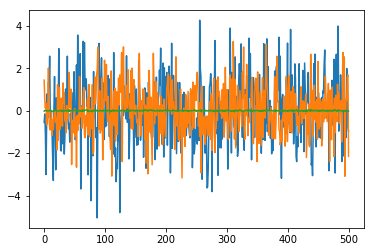

In [63]:
for i in range(3):
    x = cuda.to_cpu(dat[i])
    print (xp.std(x))
    plt.plot(x)


In [64]:
def elu(x):
    return F.leaky_relu(x)

In [65]:


class Pred(Chain):
    def __init__(this):
        s = 1
        p = 1
        super().__init__(
            p1 = L.Linear(1,32),
            pR = L.LSTM(32,32),
            p2 = L.Linear(32,1) 
        )
    
    def reset_state(this):
        this.pR.reset_state()
    
    def __call__(this,x):
        h = this.p1(x)
        h = this.pR(elu(h))
        h = this.p2(elu(h))
        y = h
        return y

prd = Pred()
xp.model_init(prd)

optimizer = optimizers.Adam()
optimizer.setup(prd)
c = 0

In [66]:
stp = 1000
dep = 100
prt = 100

def getMini(dat,mini= 50):
    N = dat.shape[0]
    R = N//mini
    r = np.random.randint(R)
    return dat[r*mini:(r+1)*mini].reshape(mini,-1)

start = time.time()

for i in range(stp):
    c += 1
    
    prd.reset_state()
    loss = 0
    
    mini = getMini(dat)
    t = xp.std(mini,axis=1).reshape(-1,1)
    for i in range(dep):
        x = mini[:,i:i+1]
        y = prd(x)
        loss += F.mean_squared_error(y,t)
    
    prd.cleargrads()
    loss.backward()
    optimizer.update()
    
    if c % prt == 0:
        print (c,loss.data,time.time()-start)
    
    
    

100 6.708254814147949 35.90344762802124
200 3.892374038696289 71.80074262619019
300 4.049471855163574 107.72836995124817
400 2.907240390777588 143.61748051643372
500 2.2439515590667725 179.49949097633362
600 2.3391008377075195 215.38248777389526
700 3.5704591274261475 251.24737691879272
800 2.193497896194458 286.42291355133057
900 2.1244072914123535 321.2858476638794
1000 2.1481213569641113 355.7345230579376


(100, 1) (100, 1)


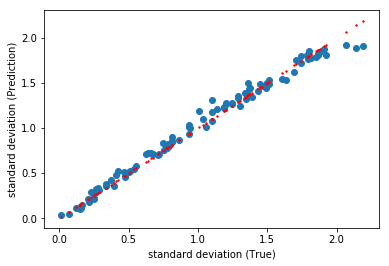

In [67]:
M = 100
val = make_data(100,M,sc=2)

if 1 == 1:    
    prd.reset_state()
    t = xp.std(val,axis=1).reshape(-1,1)
    for i in range(dep):
        x = val[:,i:i+1]
        y = prd(x)
        
print (t.shape,y.shape)

c_y = cuda.to_cpu(y.data)
c_t = cuda.to_cpu(t)
a = np.array([c_t,c_y]).reshape(2,-1).T
#print (a)
plt.scatter(a[:,0],a[:,1])
plt.scatter(a[:,0],a[:,0],c="r",s=2)
plt.xlabel("standard deviation (True)")
plt.ylabel("standard deviation (Prediction)")